In [124]:
import numpy as np
from numpy import ndarray
from helper import to_2d, tensor_size, to_2d_np

from typing import Callable, Dict, Tuple, List, NamedTuple

In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
TEST_ALL = False

# Boston data

In [127]:
from sklearn.datasets import load_boston

In [128]:
boston = load_boston()

In [129]:
data = boston.data
target = boston.target
features = boston.feature_names

## SciKit Learn Linear Regression

### Data prep

In [130]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

### Regression

In [132]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [133]:
import matplotlib.pyplot as plt

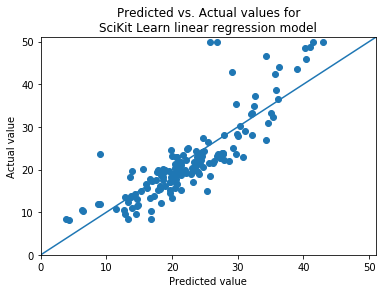

In [134]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nSciKit Learn linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("images/00_linear_real_pred_vs_actual.png");

### Testing changing feature

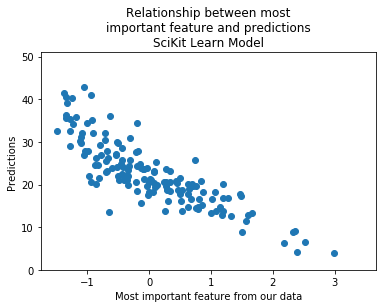

In [135]:
plt.scatter(X_test[:, 12], preds)
plt.ylim([0, 51])
plt.xlabel("Most important feature from our data")
plt.ylabel("Predictions")
plt.title("Relationship between most\nimportant feature and predictions\nSciKit Learn Model")
plt.savefig("images/03_most_important_feature_vs_predictions.png")

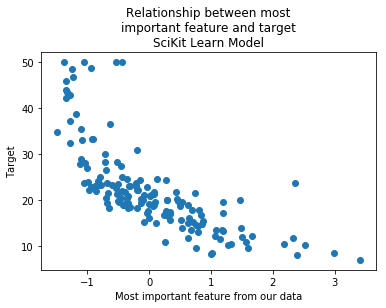

In [136]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target\nSciKit Learn Model")
plt.savefig("images/02_most_important_feature_vs_target.png")

Non linear relationship

### Model error

In [137]:
np.round(np.mean(np.abs(preds - y_test)), 4)

3.5666

In [138]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

25.4847

In [139]:
import numpy as np
np.round(lr.coef_, 2)

array([-1.01,  0.71,  0.28,  0.71, -2.21,  2.37,  0.72, -2.66,  2.63,
       -1.82, -2.33,  0.86, -4.2 ])

### Manual linear regression

In [140]:
def forward_linear_regression(X: ndarray,
                              y: ndarray,
                              weights: Dict[str, ndarray]) -> Tuple[float, Dict[str, ndarray]]:

    # assert batch sizes of X and y are equal
    assert X.shape[0] == y.shape[0]

    # assert that matrix multiplication can work
    assert X.shape[1] == weights['W'].shape[0]

    # assert that B is simply a 1x1 ndarray
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    # compute the operations on the forward pass
    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    # save the information computed on the forward pass
    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return loss, forward_info

In [141]:
def permute_data(X, y):
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [142]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:

    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    dLdW = np.dot(dNdW, dLdN)

    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, Tensor] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [143]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [144]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:

    N = np.dot(X, weights['W'])

    P = N + weights['B']

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [145]:
def init_weights(n_in) -> Dict[str, ndarray]:
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

In [146]:
def train(X: ndarray, 
          y: ndarray, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)
    y = to_2d_np(y, "col")
    start = 0

    # Initialize weights
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            try:
                weights[key] -= learning_rate * loss_grads[key]
            except:
                import pdb; pdb.set_trace()

    if return_weights:
        return losses, weights
    
    return None

In [147]:
train_info = train(X_train, y_train,
                   n_iter = 10000,
                   learning_rate = 0.0002,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

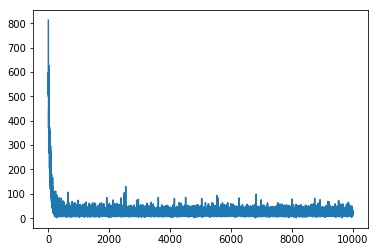

In [148]:
plt.plot(list(range(10000)), losses);

In [149]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):

    N = np.dot(X, weights['W'])

    return N + weights['B']

In [150]:
preds = predict(X_test, weights)

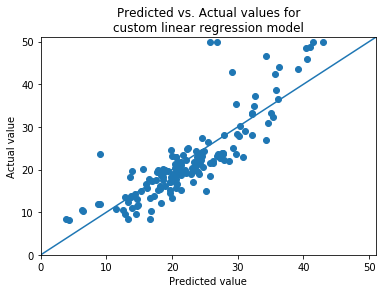

In [151]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("images/01_linear_custom_pred_vs_actual.png");

### Most important feature plots

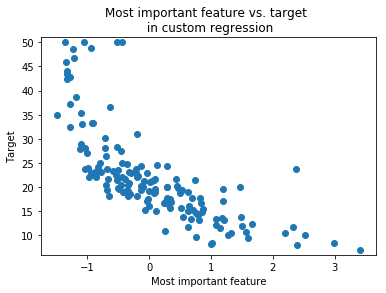

In [152]:
plt.scatter(X_test[:, 12], y_test)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Target")
plt.title("Most important feature vs. target \n in custom regression")
plt.savefig("02_most_important_feature_vs_target.png")

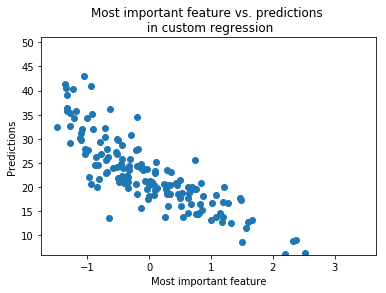

In [153]:
plt.scatter(X_test[:, 12], preds)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Predictions")
plt.title("Most important feature vs. predictions \n in custom regression")
plt.savefig("03_most_important_feature_vs_predictions.png")

In [154]:
y_test

array([48.5, 10.2, 15.2,  8.4, 18.9, 19.3, 15.4, 20.8, 29. , 23.7, 33.2,
       19.4, 17.2, 42.3, 15.1, 23.1, 12.1, 50. , 21.6, 18.5, 22.9, 25. ,
       13.9, 24.2, 18.2, 23.8, 22. , 32.4, 33.2, 17.8, 10.5, 10.5, 23.7,
       21.2, 21.7, 43.5, 38.7, 27.5, 23.7, 28. , 44. , 24.4, 46.7, 17.6,
       25. , 30.1, 20.5, 17.1,  8.1, 23.4, 17.7, 12.3, 24.7, 24.3, 22. ,
       36.5, 22.2, 22.9, 16.8, 20.3, 21.7, 37.3, 11.7, 34.9, 16.7, 28.2,
       27.9,  8.5, 11.5, 14.9, 13.1, 16.1, 13.5,  8.3, 13.9, 15.6, 11.8,
       19.8, 19.4, 21.7, 13.3, 23.1, 18.9, 18.9, 21.2,  7. , 50. , 17.8,
       19. , 10.2, 19.8, 21.4, 20.2, 33.1, 42.8, 22.3, 20. , 27. , 20. ,
       50. , 19.5, 13.4, 19.6, 18.7, 14.6, 23. , 20.5, 15. , 18.2, 18.2,
       19.6, 23.6, 20. , 20.4, 21. , 17.5, 18.8, 19.3, 14.3, 15.3, 16.1,
       19.2,  9.6, 17.1, 16.6, 23. , 22.2, 35.4, 23.3, 24.5, 28.4, 23.9,
       10.9, 31. , 10.8, 13.6, 48.8, 19.7, 21.4, 22.6, 17. , 15.6, 23.1,
        9.5, 21.5, 46. , 20.1, 26.5, 11.9, 19.4, 23

In [155]:
np.round(np.mean(np.abs(preds.reshape(-1) - y_test)), 4)

3.5656

In [156]:
np.round(np.mean(np.power(preds.reshape(-1) - y_test, 2)), 4)

25.4624

### Coefficients

In [157]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0084,  0.7097,  0.2731,  0.7161, -2.2163,  2.3737,  0.7156,
       -2.6609,  2.629 , -1.8113, -2.3347,  0.8541, -4.2003])

In [64]:
np.round(lr.coef_, 4)

array([-1.0068,  0.7055,  0.279 ,  0.7096, -2.212 ,  2.3732,  0.7165,
       -2.6633,  2.6296, -1.8159, -2.3293,  0.8574, -4.196 ])

In [65]:
np.round(weights['B'], 4)

array([[22.6214]])

In [66]:
np.round(lr.intercept_, 4)

22.6185

### Theoretical relationship between most important feature and target

In [202]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

In [203]:
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights)[:, 0]

In [204]:
test_feature[:, -1]

array([-1.5       , -1.37179487, -1.24358974, -1.11538462, -0.98717949,
       -0.85897436, -0.73076923, -0.6025641 , -0.47435897, -0.34615385,
       -0.21794872, -0.08974359,  0.03846154,  0.16666667,  0.29487179,
        0.42307692,  0.55128205,  0.67948718,  0.80769231,  0.93589744,
        1.06410256,  1.19230769,  1.32051282,  1.44871795,  1.57692308,
        1.70512821,  1.83333333,  1.96153846,  2.08974359,  2.21794872,
        2.34615385,  2.47435897,  2.6025641 ,  2.73076923,  2.85897436,
        2.98717949,  3.11538462,  3.24358974,  3.37179487,  3.5       ])

In [205]:
preds

array([29.77726712, 29.33969165, 28.84110947, 28.26271115, 27.57955678,
       26.75944214, 25.76287153, 24.54609288, 23.07060968, 21.32310211,
       19.34534349, 17.26030152, 15.26563654, 13.57598846, 12.34112108,
       11.5986546 , 11.28975697, 11.31118172, 11.56077292, 11.95760106,
       12.44320766, 12.97631533, 13.52764925, 14.07620092, 14.60653168,
       15.10679669, 15.56743784, 15.98051969, 16.33958478, 16.63982833,
       16.87837993, 17.05451934, 17.16971838, 17.22747127, 17.2329364 ,
       17.19245209, 17.11300557, 17.00172914, 16.86547791, 16.71051915])

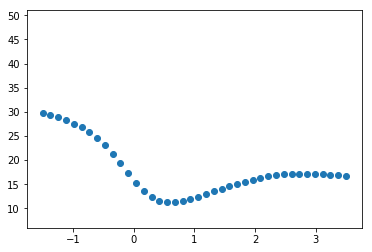

In [206]:
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
plt.savefig("04_relationship_most_impt_feat_preds.png")

# Neural network regression

In [217]:
def sigmoid(x: ndarray, 
            deriv: bool=False) -> ndarray:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + np.exp(-1.0 * x))

In [218]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [219]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:

    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))

    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

In [220]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = np.ones_like(weights['B2'])

    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)

    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1'], deriv=True)
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdW1 = np.dot(dM1dW1, dLdM1)

    loss_gradients: Dict[str, Tensor] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

In [221]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]):
    
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [222]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          return_scores: bool = False,
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)
    y_train = to_2d_np(y_train, "col")
    y_test = to_2d_np(y_test, "col")
    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []
        
    val_scores = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
        
        if return_scores:
            if i % test_every == 0 and i != 0:
                preds = predict(X_test, weights)
                val_scores.append(r2_score(preds, y_test))

    if return_weights:
        return losses, weights, val_scores
    
    return None

In [223]:
if TEST_ALL:
    num_iter = 100000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.00001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [224]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

## Learning rate tuning

In [225]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 100000,
                   learning_rate = learning_rate,
                   batch_size=23, 
                   return_losses=False, 
                   return_weights=True, 
                   return_scores=False,
                   seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return r2_score(y_test, preds)

In [226]:
if TEST_ALL:
    lrs = np.geomspace(1e-2, 1e-6, num=20)

In [227]:
if TEST_ALL:
    r2s = [r2_score_lr(lr) for lr in lrs]

In [228]:
if TEST_ALL:
    plt.semilogx(lrs, r2s)

### Evaluating best model

In [229]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   return_scores=False,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

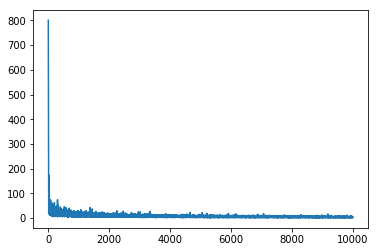

In [230]:
plt.plot(list(range(10000)), losses);

In [231]:
preds = predict(X_test, weights)

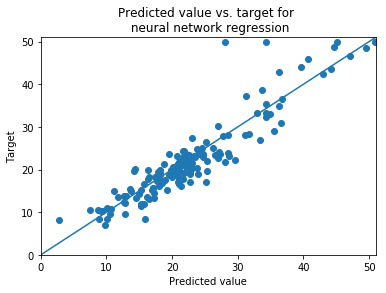

In [232]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target for \n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])
plt.savefig("07_neural_network_regression_preds_vs_target.png");

In [233]:
np.round(np.mean(np.array(np.abs(preds.reshape(-1) - y_test))), 4)

2.5289

In [234]:
np.round(np.mean(np.array(np.power(preds.reshape(-1) - y_test, 2))), 4)

13.5241

### Most important feature plots

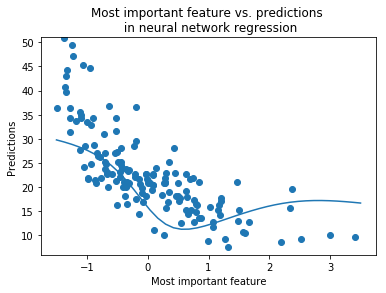

In [238]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test)
plt.ylim([6, 51])
plt.xlabel("Most important feature")
plt.ylabel("Predictions")
plt.title("Most important feature vs. predictions \n in neural network regression")
plt.savefig("08_neural_network_regression_impt_feat_vs_preds.png")

### Theoretical relationship between most important feature and target

In [237]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

In [209]:
test_feature[:, -1]

array([-1.5       , -1.37179487, -1.24358974, -1.11538462, -0.98717949,
       -0.85897436, -0.73076923, -0.6025641 , -0.47435897, -0.34615385,
       -0.21794872, -0.08974359,  0.03846154,  0.16666667,  0.29487179,
        0.42307692,  0.55128205,  0.67948718,  0.80769231,  0.93589744,
        1.06410256,  1.19230769,  1.32051282,  1.44871795,  1.57692308,
        1.70512821,  1.83333333,  1.96153846,  2.08974359,  2.21794872,
        2.34615385,  2.47435897,  2.6025641 ,  2.73076923,  2.85897436,
        2.98717949,  3.11538462,  3.24358974,  3.37179487,  3.5       ])

In [210]:
preds

array([29.77726712, 29.33969165, 28.84110947, 28.26271115, 27.57955678,
       26.75944214, 25.76287153, 24.54609288, 23.07060968, 21.32310211,
       19.34534349, 17.26030152, 15.26563654, 13.57598846, 12.34112108,
       11.5986546 , 11.28975697, 11.31118172, 11.56077292, 11.95760106,
       12.44320766, 12.97631533, 13.52764925, 14.07620092, 14.60653168,
       15.10679669, 15.56743784, 15.98051969, 16.33958478, 16.63982833,
       16.87837993, 17.05451934, 17.16971838, 17.22747127, 17.2329364 ,
       17.19245209, 17.11300557, 17.00172914, 16.86547791, 16.71051915])

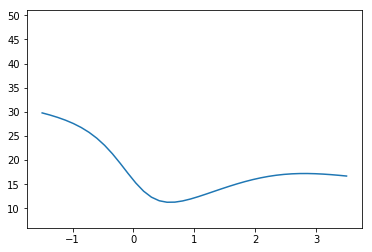

In [212]:
plt.plot(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])
plt.savefig("09_relationship_most_impt_feat_preds_nn_reg.png")

**NOTE:** I did not include any of the logistic regression stuff in the chapter.

# Logistic regression

### Helpers

In [ ]:
def sigmoid(x: Tensor, 
            deriv: bool=False) -> Tensor:
    if deriv:
        return sigmoid(x) * (1 - sigmoid(x))
    else:
        return 1 / (1 + torch.exp(-1.0 * x))

In [ ]:
def softmax(x: Tensor) -> Tensor:

    assert x.dim() == 2, \
    "Expect Tensor with shape (batch_size, num_classes), instead " + \
    "x has shape {0}".format(x.shape)
    
    def _softmax_row(row: Tensor) -> Tensor:
        
        assert row.dim() == 1, \
        "'row' should indeed be a row, instead it has shape" \
        .format(row.shape)
        
        exp_obs = torch.exp(row)
        sum_exp_obs = exp_obs.sum().item()
        softmax_obs = exp_obs / sum_exp_obs
        
        return softmax_obs

    output_rows = []
    for obs in range(x.shape[0]):
        output_row = to_2d(_softmax_row(x[obs]), "row")
        output_rows.append(output_row)
        
    return torch.cat(output_rows)
    

In [ ]:
softmax(Tensor([[10, 8, 6, 4, 2]]))

## Sklearn logistic regression

In [ ]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()
data = breast_cancer.data
target = breast_cancer.target
features = breast_cancer.feature_names

### Data prep

In [ ]:
s = StandardScaler()
data = s.fit_transform(data)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, 
                                                    test_size=0.3, 
                                                    random_state=80718,
                                                    stratify=target)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
logr = LogisticRegression(C=10e9)
logr.fit(X_train, y_train)
logr.score(X_test, y_test)

### Hand rolled logistic regression

#### Data preprocessing

In [ ]:
def predictions_to_2d(predictions: Tensor) -> Tensor:
    
    assert predictions.shape[1] == 1, \
    "Expected a column for predictions, got shape: {}".format(predictions.shape)
    
    inverse_predictions = 1 - predictions
    
    return torch.cat([predictions, inverse_predictions], dim=1)

In [ ]:
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

In [ ]:
y_train, y_test = predictions_to_2d(to_2d(y_train, "col")), predictions_to_2d(to_2d(y_test, "col"))

### Modeling functions

In [ ]:
def forward_logistic(X: Tensor,
                     y: Tensor,
                     W: Tensor, 
                     B: Tensor) -> Tensor:
    
    # For the matrix multiplication to work, 
#     assert observations.shape[1] == betas.shape[0], \
#     "Dimensions of betas and feature size do not match"
    
    N = torch.mm(X, W)
    
    O = torch.add(N, B.item())
    
    P = sigmoid(O)

    P = predictions_to_2d(P)
    
    L = cross_entropy(softmax(P), y)
    
    forward_info: Dict[str, Tensor] = {}
    forward_info['X'] = X
    forward_info['W'] = W
    forward_info['B'] = B
    forward_info['N'] = N
    forward_info['O'] = O
    forward_info['P'] = P  
    forward_info['y'] = y 
    
    return forward_info, L.sum().item() / X.shape[0]

In [ ]:
def cross_entropy(predictions: Tensor, 
                  actual: Tensor) -> Tensor:
    
    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"
    
    return -1.0 * actual * torch.log(predictions) - (1.0 - actual) * torch.log(1 - predictions)

In [ ]:
def loss_bce_softmax_deriv(predictions: Tensor, 
                           actual: Tensor) -> Tensor:

    assert predictions.shape == actual.shape, \
    "Prediction and actual must have same shape"

    return to_2d((predictions - actual)[:, 0], "col")

In [ ]:
def loss_gradients_logistic(forward_info: Dict[str, Tensor]) -> Tensor:

#     import pdb; pdb.set_trace()
    dLdP = loss_bce_softmax_deriv(forward_info['P'], 
                                  forward_info['y'])
    
    dPdO = sigmoid(forward_info['O'], deriv=True)
    
    dLdO = dLdP * dPdO
    
    dOdB = torch.ones_like(forward_info['B'])
    
    dLdB = dLdO * dOdB
    
    dOdN = torch.ones_like(forward_info['N'])
    
    dLdN = dLdO * dOdN
    
    dNdW = forward_info['X'].transpose(0, 1)

    dLdW = dNdW.mm(dLdN)
    
    return dLdW, dLdB

In [ ]:
def train(X: Tensor, 
          y: Tensor, 
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        torch.manual_seed(seed)
    start = 0

    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    for i in range(n_iter):

        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)

        start += batch_size
    
        forward_info, loss = forward_logistic(X_batch, y_batch, W, B)

        if return_losses:
            losses.append(loss)

        dLdW, dLdB = loss_gradients_logistic(forward_info)
        W -= learning_rate * dLdW
        B -= learning_rate * torch.sum(dLdB)
    
    if return_weights:
        weights: Dict[str, Tensor] = {}
        weights['W'] = W
        weights['B'] = B
        return losses, weights
    
    return None

In [ ]:
train_info = train(X_train, y_train, 
                   learning_rate = 0.001,
                   batch_size=20, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)
losses = train_info[0]
weights = train_info[1]

In [ ]:
def logistic_predict(X: Tensor, 
                     y: Tensor, 
                     weights: Dict[str, Tensor]):
    
    N = torch.mm(X, weights['W'])
    
    O = torch.add(N, weights['B'].item())
    
    P = sigmoid(O)

    return P >= 0.5

### Prediction

In [ ]:
preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [ ]:
accuracy_score(preds, y_test[:, 0])

In [ ]:
def accuracy_score_lr(learning_rate: float = 0.01, 
                      n_iter: int = 1000) -> float:
    train_info = train(X_train, y_train, 
                       learning_rate=learning_rate,
                       batch_size=20, 
                       n_iter=n_iter,
                       return_losses=True, 
                       return_weights=True, 
                       seed=80718)

    losses = train_info[0]
    weights = train_info[1]

    preds = logistic_predict(X_test, y_test, weights)[:, 0]
    
    return accuracy_score(preds, y_test[:, 0])

In [ ]:
iters = np.geomspace(10, 10000, 50)

In [ ]:
accs = [accuracy_score_lr(0.01, int(it)) for it in iters]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(iters, accs);

In [ ]:
lrs = np.geomspace(0.1, 0.00001, 50)

In [ ]:
accs_lr = [accuracy_score_lr(float(lr), 1000) for lr in lrs]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plt.xlim(iters[-1], lrs[0])
plt.semilogx(lrs, accs_lr);

### Analyzing best model

In [ ]:
train_info = train(X_train, y_train, 
                   learning_rate=0.01,
                   batch_size=20, 
                   n_iter=1000,
                   return_losses=True, 
                   return_weights=True, 
                   seed=80718)

losses = train_info[0]
weights = train_info[1]

preds = logistic_predict(X_test, y_test, weights)[:, 0]

In [ ]:
logr.coef_

In [ ]:
weights['W']

In [ ]:
def logistic_baseline_random(X: Tensor, 
                             y: Tensor,
                             seed: int = 1):
    
    torch.manual_seed(seed)
    # Initialize weights
    W = torch.empty(X.shape[1], 1).uniform_(-1, 1)
    B = torch.empty(1, 1).uniform_(-1, 1)
    
    weights: Dict[str, Tensor] = {}
    weights['W'] = W
    weights['B'] = B

    preds = logistic_predict(X, y, weights)[:, 0]
    
    return accuracy_score(preds, y[:, 0])

In [ ]:
target_2d = predictions_to_2d(to_2d(Tensor(target), "col"))

In [ ]:
logistic_baseline_random(Tensor(data), target_2d, 
                         seed=80718)

In [ ]:
a = sum(target == 1) / len(target)
a ** 2 + (1 - a) ** 2